# **Tarea 3**

En este taller se trabajará sobre la modificación del juego de escaleras y serpientes del taller anterior. Utilizando el módulo desarrollado en el taller anterior.

Se definen las librerias requeridas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

## _Punto 2:_

Escriba un método que implemente el algoritmo Q-Learning. La política de comportamiento debe ser un parámetro de entrada al método.

A continuación, se definen dos diccionarios en Python que modelan las escaleras y serpientes del tablero, donde las claves representan las casillas de inicio y los valores indican las casillas destino. El diccionario escaleras indica las casillas donde un jugador avanza automáticamente a una posición más alta, mientras que serpientes representa las casillas que obligan al jugador a retroceder, dificultando su progreso. Estas transiciones no lineales afectan la dinámica del juego y se incorporan en la función de probabilidad de transición del MDP, asegurando que el modelo refleje correctamente las reglas del juego.

In [23]:
# Definir posiciones de escaleras y serpientes
escaleras = {8: 26, 21: 82, 43: 77, 50: 91, 54: 93, 66: 87, 62: 96} # modelado de 7 escaleras, la escalera que conecta los estados 80 y 100, por practicidad no se considera al ser ambos estados terminales de victoria.
serpientes = {52: 11, 69: 33, 92: 51, 48: 9, 73: 1, 55: 7, 46: 5, 95: 24, 64: 36, 44: 22, 98: 28, 83: 19, 59: 17} # modelado de serpientes

Se definen los parámetros iniciales del entorno y del algoritmo de Q-learning. El tablero tiene 100 casillas y los estados de victoria y derrota, estos representan celdas terminales que finalizan el episodio con una recompensa positiva o negativa, respectivamente. El agente puede tomar dos acciones: avanzar o retroceder, y se mueve según el resultado de un dado cargado (probabilidades), donde ciertos números tienen mayor probabilidad de aparecer. La lista de estados representa el espacio total del entorno, del 1 al 100. Finalmente, el aprendizaje se configura para realizar mil episodios, con una tasa de aprendizaje y un factor de descuento que indica que el agente valora significativamente las recompensas futuras.

In [24]:
# informacion inicial que se suministra en el enunciado
tamanoTablero = 100
gana = {80,100} #el usuario ingresa las celdas azules
pierde = {23, 37, 45, 67, 89} #el usuario ingresa la celdas rojas
acciones = [-1,1]
probabilidades = np.array([0.1, 0.2, 0.3, 0.2, 0.1, 0.1]) #se tiene un dado cargado
estados = np.arange(1, tamanoTablero+1) # se configura de esta manera para que vaya desde el 1 al 100
episodios=1000000
alpha=0.1
gamma = 0.9

Se implementa una función que permite importar desde un archivo .csv una política de comportamiento probabilística para el agente. (proveniente de la politica soft parametrizada en el taller # 2). La función recibe como entrada el nombre del archivo y retorna un diccionario con la politica en el que cada clave corresponde a un estado (entero) y su valor asociado es otro diccionario que contiene la probabilidad de tomar cada acción posible: -1 (retroceder) y 1 (avanzar). 
Para ello, se lee el archivo con la librería de Pandas, y luego se recorre fila por fila del DataFrame para construir el diccionario completo. Finalmente, se carga la política soft desde el archivo y queda disponible para que el agente pueda usarla como política de comportamiento (piB) durante el entrenamiento.

In [25]:
def cargarPoliticaSoft(nombre_archivo="politica_soft.csv", gana=set(), pierde=set()):
    df = pd.read_csv(nombre_archivo)
    politica = {}
    for _, fila in df.iterrows():
        estado = int(fila["Estado"])
        politica[estado] = {
            -1: float(fila["Prob_-1"]),
            1: float(fila["Prob_1"])
        }
    return politica

# Cargar política
politica = cargarPoliticaSoft("politica_soft.csv")

A continuación, se convierte la política soft cargada en un DataFrame para facilitar su visualización y análisis. Primero, se construye dfPolitica como una tabla en la que cada fila contiene un estado, la probabilidad de tomar la acción -1 (retroceder) y la probabilidad de tomar la acción 1 (avanzar), extrayendo estos valores del diccionario politica.

In [26]:
# Convertir a DataFrame para impresión
dfPolitica = pd.DataFrame([
    {
        "Estado": estado,
        "Probabilidad (-1)": probs[-1],
        "Probabilidad (1)": probs[1]
    }
    for estado, probs in politica.items()
])

dfPolitica = dfPolitica.sort_values(by="Estado").reset_index(drop=True)
print(dfPolitica.to_string(index=False))

 Estado  Probabilidad (-1)  Probabilidad (1)
      1           0.272325          0.727675
      2           0.760307          0.239693
      3           0.771892          0.228108
      4           0.187850          0.812150
      5           0.802431          0.197569
      6           0.366485          0.633515
      7           0.096525          0.903475
      8           0.840027          0.159973
      9           0.141050          0.858950
     10           0.455131          0.544869
     11           0.298462          0.701538
     12           0.281620          0.718380
     13           0.615954          0.384046
     14           0.357842          0.642158
     15           0.895493          0.104507
     16           0.488477          0.511523
     17           0.662882          0.337118
     18           0.142967          0.857033
     19           0.352739          0.647261
     20           0.131588          0.868412
     21           0.823579          0.176421
     22   

Esta función, calcula el próximo estado en el juego de escaleras y serpientes considerando la acción elegida (avanzar o retroceder) y el resultado del dado. Si el estado actual es terminal, retorna el mismo estado. Luego, según la acción, suma o resta el valor del dado. Aplica una lógica de rebote cuando el estado excede los límites del tablero (mayor a 100 o menor a 1). Finalmente, si el nuevo estado corresponde a la base de una escalera o la cabeza de una serpiente, se actualiza automáticamente al estado resultante.

In [ ]:
def transicionRecompensa(estado, accion, dado, escaleras, serpientes):
    # Movimiento inicial
    nuevoEstado = estado + (accion * dado)

    # Lógica de rebote
    if nuevoEstado < 1:
        nuevoEstado = abs(nuevoEstado) + 1
    elif nuevoEstado > 100:
        if estado == 99 and dado in [1, 2]:
            nuevoEstado = 100
        else:
            exceso = nuevoEstado - 100
            nuevoEstado = 100 - exceso

    # Aplicar efecto de escaleras o serpientes
    if nuevoEstado in serpientes:
        nuevoEstado = serpientes[nuevoEstado]
    elif nuevoEstado in escaleras:
        nuevoEstado = escaleras[nuevoEstado]

    # Asignación de recompensa
    if nuevoEstado in pierde:
        recompensa = -100
    elif nuevoEstado in gana:
        recompensa = 100
    else:
        recompensa = -1

    return nuevoEstado, recompensa

La siguiente función, implementa el algoritmo Q-learning en forma tabular. Inicializa una tabla Q (Q-table) con valores cero para cada estado y acción posible, y durante un número definido de episodios, simula juegos donde el agente parte desde la casilla 1 y actúa según una política de comportamiento soft importada (piB). En cada paso, lanza un dado con una distribución específica, calcula el nuevo estado y la recompensa mediante la función de transición, y actualiza el valor de Q para el par (estado, acción) actual utilizando la fórmula de Q-learning, considerando la recompensa recibida y el valor máximo esperado del nuevo estado. Si el estado alcanzado es terminal, el valor futuro se anula. Además, se registra la evolución del valor de Q para el estado inicial con el fin de analizar la convergencia. Al finalizar, la función deriva una política óptima tomando, para cada estado no terminal, la acción con mayor valor Q aprendido, y retorna la tabla Q, la política aprendida y el historial de valores del estado inicial.

In [28]:
def qLearning(piB, episodios, alpha, gamma,
              tamanoTablero, gana, pierde,
              escaleras, serpientes, probabilidades,
              transicionFunc):
    
    Q = defaultdict(lambda: {-1: 0.0, 1: 0.0})
    historial = []

    for ep in range(episodios):
        estado = 1

        while estado not in gana and estado not in pierde:
            acciones = piB[estado]
            listaAcciones = list(acciones.keys())
            listaProbs = list(acciones.values())
            accion = np.random.choice(listaAcciones, p=listaProbs)

            dado = np.random.choice(np.arange(1, 7), p=probabilidades)
            nuevoEstado, recompensa = transicionFunc(
                estado, accion, dado, escaleras, serpientes)

            maxQNuevo = max(Q[nuevoEstado].values()) if nuevoEstado not in gana and nuevoEstado not in pierde else 0
            Q[estado][accion] += alpha * (recompensa + gamma * maxQNuevo - Q[estado][accion])

            estado = nuevoEstado

        # Guardar el valor Q máximo desde el estado inicial al final del episodio
        maxQInicio = max(Q[1].values())
        historial.append(maxQInicio)

    politicaOptima = {}
    for s in range(1, tamanoTablero + 1):
        if s in gana or s in pierde:
            continue
        acciones = Q[s]
        mejorAccion = max(acciones, key=acciones.get)
        politicaOptima[s] = mejorAccion

    return Q, politicaOptima, historial

A continuación, se Esta línea ejecuta el entrenamiento con Q-learning usando la política de comportamiento y la configuración del entorno (tablero, escaleras, serpientes, recompensas). Devuelve la Q-table aprendida, la política óptima derivada y un historial que muestra cómo evoluciona el valor Q del estado inicial durante los episodios.

In [29]:
# Ejecutar Q-learning
Q, politicaOptima, historialQ = qLearning(politica, episodios, alpha, gamma, tamanoTablero, gana, pierde, escaleras, serpientes, probabilidades, transicionFunc=transicionRecompensa)

La siguiente función, evalúa si la política aprendida por el agente es óptima con respecto a los valores Q aprendidos. Recorre todos los estados del entorno (excepto los terminales de victoria o derrota), y para cada uno, compara la acción elegida por la política (accionPi) con la mejor acción según la Q-table (accionOptimaQ, es decir, la acción con mayor valor Q). Guarda los resultados en una lista de diccionarios que incluyen el estado, ambas acciones, y una verificación booleana de si coinciden. Luego convierte esa lista en un DataFrame (dfComparacion) para análisis detallado y determina si la política es completamente óptima con esOptima, que será True solo si en todos los estados las acciones coinciden. La función retorna tanto el DataFrame como el resultado booleano.

In [31]:
def verificarOptimalidad(politica, Q, estados, gana, pierde):
    resultados = []

    for s in estados:
        if s in gana or s in pierde:
            continue

        accionesQ = Q[s]
        accionOptimaQ = max(accionesQ, key=accionesQ.get)
        accionPi = politica.get(s, None)

        resultados.append({
            'Estado': s,
            'Acción política aprendida': accionPi,
            'Acción óptima según Q': accionOptimaQ,
            '¿Es óptima?': accionPi == accionOptimaQ
        })

    dfComparacion = pd.DataFrame(resultados)
    esOptima = dfComparacion['¿Es óptima?'].all()

    return dfComparacion, esOptima

A continuación, se ejecuta el algoritmo de Q-learning con todos los parámetros del entorno y del aprendizaje ya definidos, y asigna los resultados a las variables Q y politicaOptima (la mejor acción por estado según Q). 

El tercer valor retornado por la función, que corresponde al historial del valor Q en el estado inicial a lo largo de los episodios, se ignora con el guion bajo _ porque no se necesita en ese momento.

In [32]:
Q, politicaOptima, _ = qLearning(politica, episodios, alpha, gamma, tamanoTablero, gana, pierde, escaleras, serpientes, probabilidades, transicionFunc=transicionRecompensa)

A continuación, se evalúa si la política aprendida (politicaOptima) es óptima respecto a los valores de la tabla Q. Para ello, se llama a la función verificarOptimalidad, que compara para cada estado no terminal la acción que dicta la política con la acción que maximiza Q. El resultado se almacena en un DataFrame que muestra, estado por estado,  si la política coincide con Q, y en "esOptima", un valor booleano que indica si la política es óptima en todos los estados.

In [33]:
dfCheck, esOptima = verificarOptimalidad(politicaOptima, Q, estados, gana, pierde)
display(dfCheck)
print("¿La política aprendida es óptima respecto a Q?", esOptima)

,Estado,Acción política aprendida,Acción óptima según Q,¿Es óptima?
0,1,1,1,True
1,2,1,1,True
2,3,1,1,True
3,4,1,1,True
4,5,1,1,True
...,...,...,...,...
88,95,-1,-1,True
89,96,1,1,True
90,97,1,1,True
91,98,-1,-1,True


¿La política aprendida es óptima respecto a Q? True


In [34]:
dfCheck, esOptima = verificarOptimalidad(politicaOptima, Q, estados, gana, pierde)

In [36]:
def visualizarPoliticaConErrores(politicaOptima, dfCheck, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    # Crear conjunto de estados con error de optimalidad
    estadosErroneos = set(dfCheck[dfCheck["¿Es óptima?"] == False]["Estado"])

    for i in range(10):
        for j in range(10):
            # Zig-zag
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            elif estado in estadosErroneos:
                simbolo = "❌"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTableroErrores = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTableroErrores

In [37]:
dfTableroErrores = visualizarPoliticaConErrores(
    politicaOptima, dfCheck, gana, pierde
)
display(dfTableroErrores)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,➡️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,⬅️
F8,🎯,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,➡️,⬅️,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,➡️
F5,➡️,➡️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,⬅️,⬅️,➡️,➡️,⬅️,➡️,⬅️
F2,⬅️,⬅️,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️


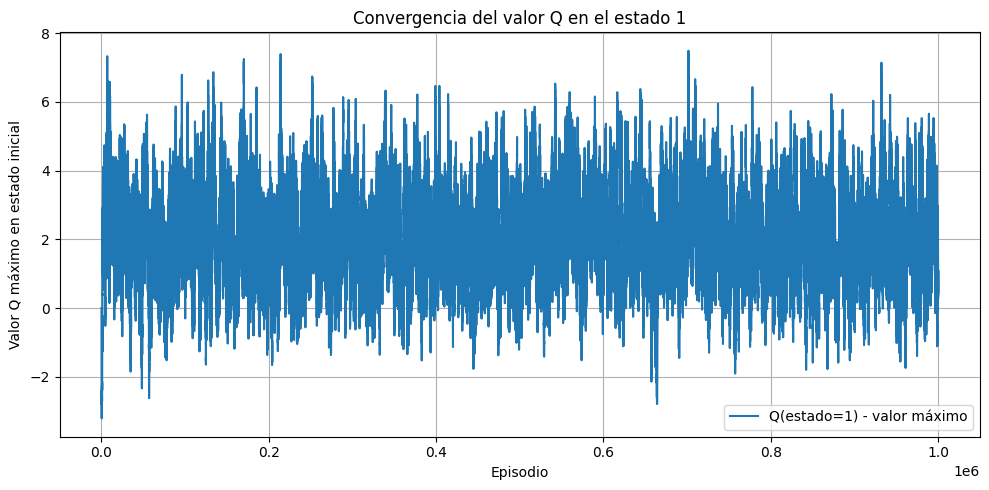

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(historialQ, label="Q(estado=1) - valor máximo")
plt.xlabel("Episodio")
plt.ylabel("Valor Q máximo en estado inicial")
plt.title("Convergencia del valor Q en el estado 1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
def visualizarPoliticaTablero(politicaOptima, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    for i in range(10):
        for j in range(10):
            # Zig-zag del tablero
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            # Determinar símbolo para cada casilla
            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo  # invertir verticalmente

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTablero = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTablero

In [22]:
# Visualizar política óptima en forma de tablero
dfPoliticaTablero = visualizarPoliticaTablero(politicaOptima, gana, pierde)
display(dfPoliticaTablero)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,⬅️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,⬅️
F8,🎯,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,➡️,⬅️,⬅️,⬅️,➡️,⬅️,💀,➡️,⬅️,➡️
F6,➡️,⬅️,➡️,⬅️,⬅️,⬅️,⬅️,➡️,⬅️,➡️
F5,⬅️,⬅️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,⬅️,⬅️,➡️,➡️,➡️,➡️,⬅️
F2,⬅️,⬅️,➡️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,⬅️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
